In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from keras.regularizers import l2
from lib.data.utils import train_data, targets, features, split_dataframe
from lib.data.windowed_data import WTSMaker
from lib.data.plot import plot_predictions
from lib.models.estimators import PollutionEstimator
from lib.models.on_the_fly import OnTheFlyLSTM
# from lib.models import DirectRnn
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier


import tensorflow as tf
# tf.get_logger().setLevel('INFO')
import keras
from keras.callbacks import TensorBoard as TB, EarlyStopping as ES, ReduceLROnPlateau as RLRP
from keras.optimizers import Adam, SGD
import keras_tuner as kt
import seaborn as sns
sns.set_theme("notebook", style="whitegrid", rc={"figure.dpi": 100})
import pandas as pd

data_dir = "../data/"

df = train_data(data_dir, delta=False)
# in_day_features = CalendarFourier("D", 8)
# time_features = DeterministicProcess(
#     df.to_period("H").index,
#     constant=False,
#     additional_terms=[in_day_features],
#     drop=True
# ).in_sample().to_timestamp()

# df = df.join(time_features, how="left")
all_features = features  # + time_features.columns.to_list()

train_df, valid_df = split_dataframe(df, 0.2, 0.0)

full_train_df = pd.concat(train_df)
for i in range(2):
    train_df[i].loc[:, targets] = (train_df[i][targets] - full_train_df[targets].mean()) / full_train_df[targets].std()
valid_df.loc[:, targets] = (valid_df[targets] - full_train_df[targets].mean()) / full_train_df[targets].std()
(X_train, X_valid), (y_train, y_valid) = ([td[all_features] for td in train_df], valid_df[all_features]), ([
    td[targets] for td in train_df], valid_df[targets])

l = l2(0.01)
rnn_kwargs = {"dropout": 0.1, "recurrent_dropout": 0.1,
              "kernel_regularizer": l, "recurrent_regularizer": l, "bias_regularizer": l, "activity_regularizer": l}


def model_builder(hp):
    double_rnn = hp.Boolean("double_rnn")
    input_days = hp.Int("input_days", min_value=1, max_value=7, step=1)
    n_recursive_units = hp.Choice("n_recursive_units", values=[8, 64, 256])
    if double_rnn:
        second_layer = [n_recursive_units]
    else:
        second_layer = []
    model = OnTheFlyLSTM(len(all_features), len(targets), n_recursive_units=(
        [n_recursive_units] + second_layer), rnn_kwargs={}, input_days=input_days)
    estimator = PollutionEstimator(all_features, targets, model, targets_normalization=False)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    la = hp.Choice("learning_algorithm", values=["adam", "nadam"])
    estimator.adapt_training(train_df)
    estimator.compile(optimizer=keras.optimizers.deserialize(
        {"class_name": la, "config": {"learning_rate": lr}}), loss="mse")
    return estimator


In [2]:
tuner = kt.RandomSearch(model_builder, objective="val_loss", max_trials=1000, directory="tuning", project_name="random_search", distribution_strategy=tf.distribute.MirroredStrategy())
tuner.search(X_train, y_train, validation_data=valid_df, shift_hours=1, epochs=300, batch_size=128, callbacks=[ES(patience=40)])

Trial 333 Complete [00h 07m 52s]
val_loss: 0.06487971544265747

Best val_loss So Far: 0.04833192005753517
Total elapsed time: 13h 05m 00s

Search: Running Trial #334

Value             |Best Value So Far |Hyperparameter
False             |False             |double_rnn
7                 |4                 |input_days
256               |8                 |n_recursive_units
0.0033189         |0.002401          |learning_rate
adam              |adam              |learning_algorithm

Epoch 1/300
44/44 [==============================] - 50s 938ms/step - loss: 0.1998 - val_loss: 0.1505
Epoch 2/300
44/44 [==============================] - 7s 147ms/step - loss: 0.0780 - val_loss: 0.0899
Epoch 3/300
44/44 [==============================] - 6s 122ms/step - loss: 0.0629 - val_loss: 0.0611
Epoch 4/300
44/44 [==============================] - 5s 116ms/step - loss: 0.0514 - val_loss: 0.0660
Epoch 5/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0421 - val_loss: 0.0747
Epoch 6/30

KeyboardInterrupt: 

In [2]:
tuner = kt.Hyperband(model_builder, objective="val_loss", max_epochs=300, factor=5,
                        directory="tuning", project_name="on_the_fly_lstm_2", executions_per_trial=2)
tuner.search(X=X_train, y=y_train, validation_data=valid_df, shift_hours=1, batch_size=128, callbacks=[ES(patience=70)])


Trial 266 Complete [00h 05m 59s]
val_loss: 0.10453946143388748

Best val_loss So Far: 0.04966453090310097
Total elapsed time: 01h 07m 37s
INFO:tensorflow:Oracle triggered exit


In [3]:
tuner.results_summary() 

Results summary
Results in tuning/on_the_fly_lstm_2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0189 summary
Hyperparameters:
double_rnn: False
input_days: 6
n_units: 64
learning_rate: 0.002539116946139317
learning_algorithm: adam
tuner/epochs: 60
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0160
Score: 0.04966453090310097

Trial 0188 summary
Hyperparameters:
double_rnn: True
input_days: 3
n_units: 64
learning_rate: 0.007332570942268777
learning_algorithm: adam
tuner/epochs: 60
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0177
Score: 0.0507013238966465

Trial 0243 summary
Hyperparameters:
double_rnn: False
input_days: 7
n_units: 16
learning_rate: 0.004080390057565442
learning_algorithm: adam
tuner/epochs: 300
tuner/initial_epoch: 60
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0240
Score: 0.05264592170715332

Trial 0240 summary
Hyperparameters:
double_rnn: False
input_days: 7
n_units: 16
learning_rat

In [3]:
import json
import os
path = "tuning/random_search"
results = {}
for dir in os.listdir(path):
    if dir.startswith("trial"):
        with open(os.path.join(path, dir, "trial.json")) as f:
            result = json.load(f)
        id = result["trial_id"]
        results[id] = {"score": result["score"]}
        for key, value in result["hyperparameters"]["values"].items():
            results[id][key] = value

In [4]:
results_df = pd.DataFrame.from_dict(results, orient="index").astype({"learning_algorithm": "category", "double_rnn": "category"})

In [5]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0094 to 0229
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   score               333 non-null    float64 
 1   double_rnn          334 non-null    category
 2   input_days          334 non-null    int64   
 3   n_recursive_units   334 non-null    int64   
 4   learning_rate       334 non-null    float64 
 5   learning_algorithm  334 non-null    category
dtypes: category(2), float64(2), int64(2)
memory usage: 13.9+ KB


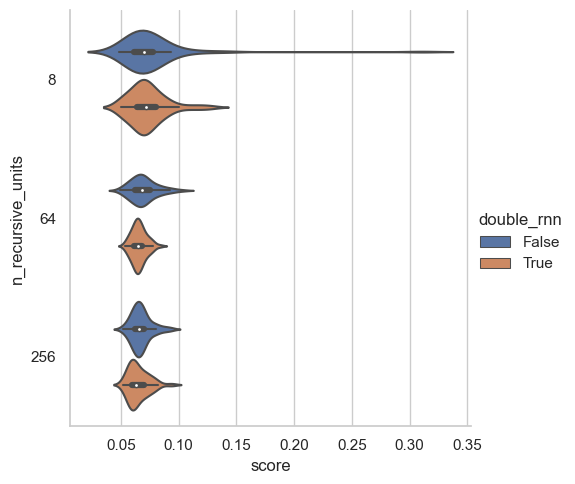

In [8]:
sns.catplot(data=results_df, x="score", y="n_recursive_units", hue="double_rnn", orient="h", kind="violin")

In [17]:
pd.DataFrame.melt?

Signature:
pd.DataFrame.melt(
    self,
    id_vars=None,
    value_vars=None,
    var_name=None,
    value_name: 'Hashable' = 'value',
    col_level: 'Level' = None,
    ignore_index: 'bool' = True,
) -> 'DataFrame'
Docstring:
Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.

This function is useful to massage a DataFrame into a format where one
or more columns are identifier variables (`id_vars`), while all other
columns, considered measured variables (`value_vars`), are "unpivoted" to
the row axis, leaving just two non-identifier columns, 'variable' and
'value'.

Parameters
----------
id_vars : tuple, list, or ndarray, optional
    Column(s) to use as identifier variables.
value_vars : tuple, list, or ndarray, optional
    Column(s) to unpivot. If not specified, uses all columns that
    are not set as `id_vars`.
var_name : scalar
    Name to use for the 'variable' column. If None it uses
    ``frame.columns.name`` or 'variable'.
value_name : scalar,

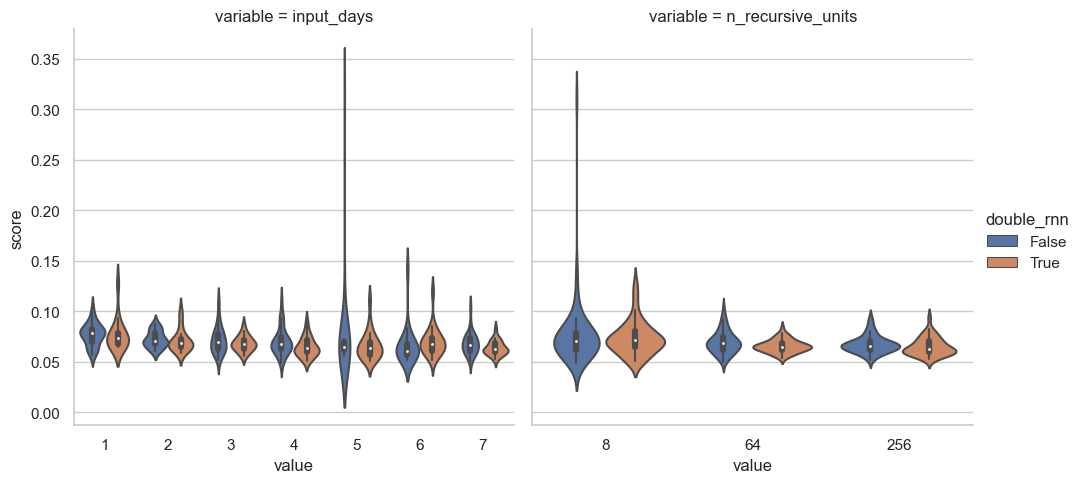

In [22]:
sns.catplot(data=results_df[["score", "input_days", "n_recursive_units", "double_rnn"]].melt(id_vars=["score", "double_rnn"]), x="value", y="score", col="variable", hue="double_rnn", kind="violin", sharex=False)

In [9]:
n_units = [64]
itd = [4]
models = [OnTheFlyLSTM(len(all_features), len(targets), n_recursive_units=[nu, 3], rnn_kwargs={}, input_days=d, name=f"n{nu}/id{d}") for nu in n_units for d in itd]
estimators = [PollutionEstimator(all_features, targets, model, deltas=False, name=model.name) for model in models]
for e in estimators:
    name = f"otf_dblrnn_regul_delta/adam/{e.name}"
    e.adapt_training(train_df)
    e.compile(optimizer=keras.optimizers.deserialize(
        {"class_name": "adam", "config": {"learning_rate": 0.005}}), loss="mse")
    e.train(train_df, epochs=2000, validation_data=valid_df, shift_hours=1, batch_size=128, callbacks=[
        TB(f"../logs/{name}"), ES(patience=100, restore_best_weights=True)])

Epoch 1/2000


2023-04-22 12:06:12.269013: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


     44/Unknown - 4s 40ms/step - loss: 0.8818

2023-04-22 12:06:14.566528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


44/44 [==============================] - 5s 51ms/step - loss: 0.8818 - val_loss: 0.5275
Epoch 2/2000
 3/44 [=>............................] - ETA: 1s - loss: 0.7528

2023-04-22 12:06:15.002488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


44/44 [==============================] - 1s 32ms/step - loss: 0.5114 - val_loss: 0.2358
Epoch 3/2000
44/44 [==============================] - 1s 32ms/step - loss: 0.3138 - val_loss: 0.1922
Epoch 4/2000
44/44 [==============================] - 1s 30ms/step - loss: 0.2677 - val_loss: 0.1609
Epoch 5/2000
44/44 [==============================] - 1s 30ms/step - loss: 0.2442 - val_loss: 0.1581
Epoch 6/2000
44/44 [==============================] - 1s 31ms/step - loss: 0.2249 - val_loss: 0.1612
Epoch 7/2000
44/44 [==============================] - 1s 31ms/step - loss: 0.2106 - val_loss: 0.1693
Epoch 8/2000
44/44 [==============================] - 2s 33ms/step - loss: 0.1917 - val_loss: 0.1729
Epoch 9/2000
44/44 [==============================] - 1s 33ms/step - loss: 0.1769 - val_loss: 0.1864
Epoch 10/2000
44/44 [==============================] - 1s 33ms/step - loss: 0.1667 - val_loss: 0.1972
Epoch 11/2000
44/44 [==============================] - 1s 31ms/step - loss: 0.1578 - val_loss: 0.1978
E

1/1 [==============================] - 1s 777ms/step


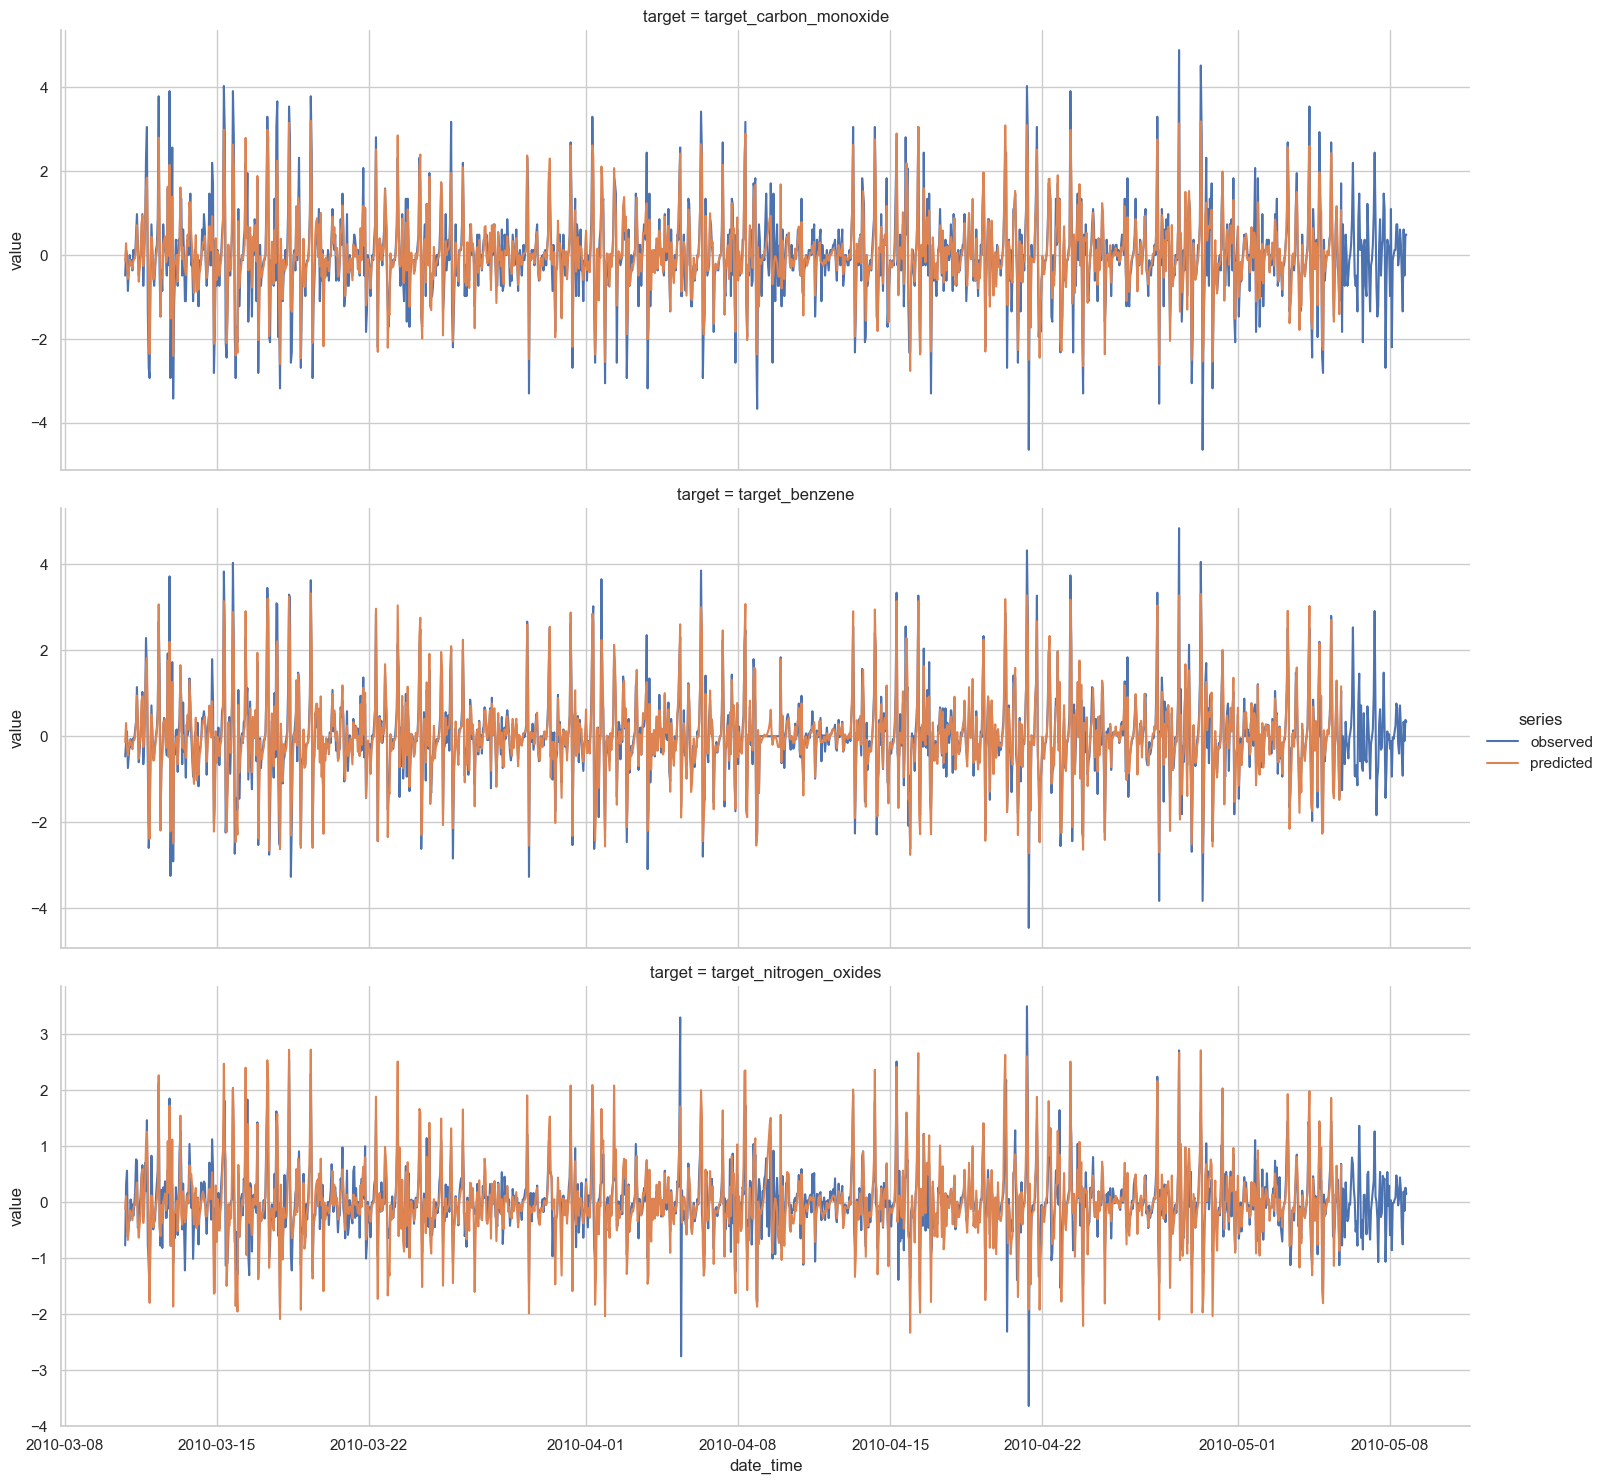

In [10]:
fg = plot_predictions(valid_df, estimators[0], aspect=3, facet_kws={
                      "sharey": False})  # , "xlim": (pd.Timestamp("2010-12-15"), pd.Timestamp("2010-12-25"))})


In [29]:
estimators[0].assess(valid_df, "mse")


1/1 [==============================] - 0s 50ms/step - loss: 807.6882


KeyError: 'mse'

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(train_df[all_features], train_df[targets])
